In [4]:
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration

In [5]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA is available: {cuda_available}")

if cuda_available:
    # Print CUDA device information
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"Current CUDA device: {device_name}")


CUDA is available: True
Current CUDA device: NVIDIA GeForce RTX 4090


In [7]:
model = LlavaForConditionalGeneration.from_pretrained(
    "llava-hf/llava-1.5-7b-hf",
    torch_dtype=torch.float16,
).cuda()
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
model.config

LlavaConfig {
  "_name_or_path": "llava-hf/llava-1.5-7b-hf",
  "architectures": [
    "LlavaForConditionalGeneration"
  ],
  "ignore_index": -100,
  "image_token_index": 32000,
  "model_type": "llava",
  "pad_token_id": 32001,
  "projector_hidden_act": "gelu",
  "text_config": {
    "_name_or_path": "lmsys/vicuna-7b-v1.5",
    "architectures": [
      "LlamaForCausalLM"
    ],
    "max_position_embeddings": 4096,
    "model_type": "llama",
    "rms_norm_eps": 1e-05,
    "torch_dtype": "float16",
    "vocab_size": 32064
  },
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.41.2",
  "vision_config": {
    "hidden_size": 1024,
    "image_size": 336,
    "intermediate_size": 4096,
    "model_type": "clip_vision_model",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "patch_size": 14,
    "projection_dim": 768,
    "vocab_size": 32000
  },
  "vision_feature_layer": -2,
  "vision_feature_select_strategy": "default"
}

In [10]:
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)

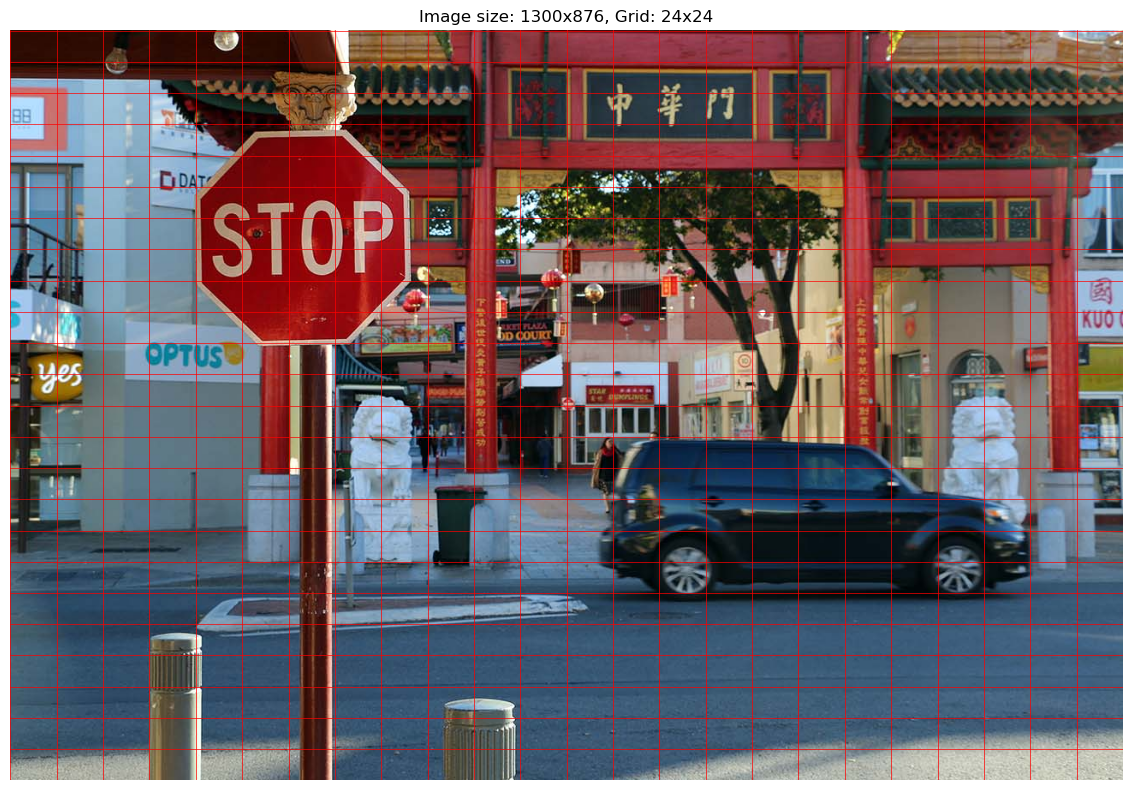

In [11]:
import matplotlib.pyplot as plt

def draw_grid_on_image(image, num_patches):
    fig, ax = plt.subplots(1, figsize=(12, 8))  # Increased figure size for better visibility
    ax.imshow(image)

    # Get original image dimensions
    width, height = image.size

    # Calculate the patch size for each dimension
    patch_width = width / num_patches
    patch_height = height / num_patches

    # Draw the grid
    for i in range(num_patches):  # Changed from num_patches + 1 to num_patches
        ax.axvline(x=i * patch_width, color='r', linewidth=0.5)
        ax.axhline(y=i * patch_height, color='r', linewidth=0.5)

    plt.title(f"Image size: {width}x{height}, Grid: {num_patches}x{num_patches}")
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.tight_layout()  # Adjust the plot to remove any extra white space
    plt.show()

# Parameters
num_patches = 336 // 14  # This gives us 24

# Draw the grid on the image
draw_grid_on_image(image, num_patches)


In [14]:
prompt = "USER: <image>\nWhat's the content of the image? ASSISTANT:"
inputs = processor(text=prompt, images=image, return_tensors="pt").to(0, torch.float16)

In [15]:
# Generate
generate_ids = model.generate(**inputs, max_new_tokens=30)
processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

"USER:  \nWhat's the content of the image? ASSISTANT: The image features a city street with a stop sign, a red building, and a tree. There is also a black car driving down the street."

# Ideas
* Position embedding that is a function of (i, x, y) where x and y specify an image patch
    * Such as Rope(i) + learnable_embedding(x) + learnable_embedding(y)